## Load data

In [22]:
from zipfile import ZipFile
import pandas as pd

In [23]:
with ZipFile("youtube_comments_climate_change.zip", 'r') as zip_ref:
    zip_ref.extractall()
    print(zip_ref.namelist())

[]


In [24]:
path = "youtube_comments_climate_change/500_comments_raw.csv"
data = pd.read_csv(path, sep=";", encoding='utf-8')
data = data.dropna(subset=['text'])

list(data.columns)

['id',
 'Youtube_id',
 'replyCount',
 'likeCount',
 'publishedAt',
 'authorName',
 'text',
 'authorChannelId',
 'authorChannelUrl',
 'isReply',
 'isReplyTo',
 'isReplyToName']

In [26]:
data=data.drop(['id','Youtube_id','authorChannelUrl','authorChannelId','isReplyTo','isReplyToName'],axis=1)
data.head()

,replyCount,likeCount,publishedAt,authorName,text,isReply
0,27.0,127.0,24.01.17 18:41,ProgressivePepe,This will happen if the idiot trump climate change denier dont get impeached,0.0
1,26.0,51.0,24.01.17 20:40,Big-Bonkin-Head,My friends don&#39;t believe in global warming... They listen to Fox News and have no way of disproving the facts I give them. All they can say is &quot;It isn&#39;t any hotter than it has been&qu...,0.0
2,22.0,6.0,24.01.17 18:43,Chairman,"Even if no human would polute the athmosphere with CO² or other gases anymore, the greenhouse effect can no longer be stopped.<br />It wouldn&#39;t make a difference in the long term",0.0
3,18.0,123.0,24.01.17 18:59,The Alternative Facts Coterie,What Is everyone so concerned about? Human beings are a resilient and resourceful people. We will just use evolution to evolve Into a mermaid people. Problem solved!,0.0
4,12.0,50.0,24.01.17 18:32,PlayTrailers,Very spooky... better build a boat.,0.0


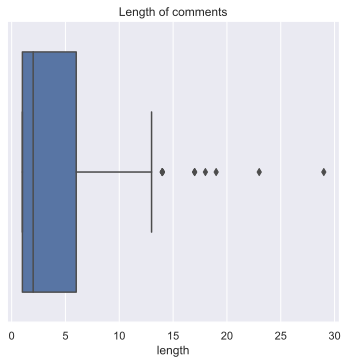

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set()

data["length"] = data['text'].str.split().apply(len).value_counts()
sns.catplot(x="length", kind="box", data=data).set(title="Length of comments")

## Preprocessing 

### Removing HTML tags

In [28]:
from html2text import HTML2Text

h = HTML2Text()
h.ignore_links = True

data['text'] = data['text'].apply(lambda x: h.handle(x))

### Removing user names

In [29]:
data.text.unique().shape # number of comments overall

(381,)

In [30]:
data[data['isReply'] == 1.0 ]['isReply'].sum()  # number of replies

167.0

In [31]:
import re

user_names = [name for name in data['authorName'].unique()]

data['text'] = data['text'].str.replace('|'.join(map(re.escape, user_names)), '')

### Removing Links

In [33]:
http_link_pattern = r'http\S+'
bitly_link_pattern = r'bit.ly/\S+'
print(data[data['text'].str.contains(http_link_pattern)]['text'])

182                                                                                                                                                   You need to see this  \nhttps://youtu.be/SBLpt-vQs8s\n\n
218                                                                                                              One of those boat cars so you can easily go from land to water:\nhttp://dailym.ai/2jZmD9G\n\n
219                                                                                                    Here's a video I made based on the Eat Less Meat idea:\nhttps://www.youtube.com/watch?v=lLhEmGx8YQE\n\n
341    Gameathon From MIT: https://www.technologyreview.com/s/43256/global-warming-\nbombshell/ From the UK:\nhttp://www.telegraph.co.uk/comment/columnists/christopherbooker/667982/Climate-\nchange-this-...
Name: text, dtype: object


In [34]:
data['text'] = data['text'].str.replace(http_link_pattern, '')
data['text'] = data['text'].str.replace(bitly_link_pattern, '')

### Tokenizing

In [35]:
import nltk
#nltk.download('punkt')
from nltk.corpus import stopwords
#nltk.download('stopwords')

from tqdm.notebook import tqdm
punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem

def clean_text(text, bigrams=False):
    text = text.lower()
    text = re.sub('['+punctuation + ']+', ' ', text) # strip punctuation
    text = re.sub('\s+', ' ', text) # remove double spacing
    text = re.sub('([0-9]+)', '', text) # remove numbers
    tokens = nltk.word_tokenize(text)
    tokens_without_sw = [word for word in tokens if not word in stopwords.words()]
    tokens_without_sw = [word_rooter(word) if '#' not in word else word
                        for word in tokens_without_sw]
    text = ' '.join(tokens_without_sw)
    return text

In [37]:
from tqdm import tqdm

tqdm.pandas()

data['cleaned'] = data['text'].progress_apply(clean_text)

100%|██████████| 384/384 [00:36<00:00, 10.51it/s]


## Topic Modelling

### Turn text into vectors

The vectorizer object will be used to transform text to vector form.

Explanation of params:

- max_df=0.9 discard words appearing in >90% of comments

- min_df=25 discard words appearing in less than 25 comments to avoid adding noise to model

Word_frequency_feature_names tells what word each column in the matric represents.

TODO: Turning text into sparse matrix?

In [58]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_df=0.9, token_pattern='\w+|\$[\d\.]+|\S+') 

word_frequency = vectorizer.fit_transform(data['cleaned']).toarray() # apply transformation

word_frequency_feature_names = vectorizer.get_feature_names()

In [59]:
print(' '.join(map(str, word_frequency_feature_names))) #words(tokens) that made it through filtering

# abl abudabi ac accept accomplish accord account accur acid acknowledg across act activ actual adapt addict ade adió admit adult advanc aerosol affect afford afraid african age agenc agenda ago agre agreement agricultur agw aim air airplan alarmist algor aliv allah allow almost along alpin alreadi although aluminum alway amaz ambit america american amiright among amount amsterdam angel angela anim annapoli annihil annoy anoth answer ant antarct antarctica anymor anyon anyth anytim anyway anywher apart apocalyps approv aqua aquaf arctic area around artifici ask assum asteroid astonomi athmospher atlant atlanti atmospher atom australia averag avoid award away b babi back bad baltic baltimor bangkok bangladesh bangladeshi bar barium base bash basi basic bbc bbhead bc be beach beat beauti becom becuas began begun behind believ beliv berlin besid best better big bigger biggest biiiiiig biiiiiiiiiig billion billionair biodivers biolog bit bite biuld blame blind blog blown boat bomb bombshel

In [60]:
word_frequency.shape #(nr of comments, nr of tokens after filtering)

(384, 1568)

In [61]:
word_frequency

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [62]:
from sklearn.decomposition import LatentDirichletAllocation

number_of_topics = 10

model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

In [63]:
model.fit(word_frequency)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [64]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["%d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [65]:
no_top_words = 10
display_topics(model, word_frequency_feature_names, no_top_words)

,Topic 0 words,0 weights,Topic 1 words,1 weights,Topic 2 words,2 weights,Topic 3 words,3 weights,Topic 4 words,4 weights,Topic 5 words,5 weights,Topic 6 words,6 weights,Topic 7 words,7 weights,Topic 8 words,8 weights,Topic 9 words,9 weights
0,warm,11.1,warm,7.1,world,9.1,venic,11.1,chang,8.1,build,9.8,ice,11.1,time,11.1,go,9.0,need,15.0
1,global,10.1,citi,6.1,trump,8.1,citi,10.5,climat,7.1,chang,7.1,human,10.1,would,10.1,rise,7.1,year,12.1
2,climat,10.1,rise,6.1,go,7.6,water,8.9,miami,6.1,wall,6.7,age,9.1,level,8.1,level,6.1,cool,7.1
3,ice,10.1,ocean,6.0,like,7.1,would,8.1,level,5.1,global,5.1,happen,8.1,year,8.1,get,5.1,warm,6.1
4,chang,9.1,global,5.1,way,6.1,happen,7.1,rise,5.1,ye,5.1,speci,6.1,make,7.1,think,5.1,cycl,6.1
5,trump,7.1,water,4.1,hous,6.1,like,6.1,underwat,4.1,caus,5.1,good,6.1,warm,7.1,new,4.1,gon,5.1
6,say,7.1,level,4.1,year,6.1,global,6.0,peopl,4.1,weather,5.1,atmospher,6.1,global,6.1,flood,4.1,earth,5.1
7,human,7.1,happen,4.1,citi,6.1,live,6.0,go,4.1,warm,5.1,extinct,6.1,co,6.1,china,4.1,bigger,5.1
8,scientist,6.1,come,4.0,water,6.1,fix,5.1,idiot,4.1,water,4.3,would,5.1,know,6.1,water,3.1,boat,4.1
9,news,5.1,get,3.1,peopl,5.1,year,5.1,theori,4.1,gon,4.1,chang,5.1,trump,6.1,make,3.1,way,4.1
